In [32]:
import numpy as np
from PIL import Image
import keras
import os
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

# Prepare the data

In [33]:
# may need a box as parameter this is for 3*3 box
def get_matrix(path, d):
    x = []
    y = []
    img = Image.open(path).resize((225,225))
    img_gray = img.convert('L')
    print(img.size)
    img_size = img.size[0]
    for j in range(0,img_size-3,d):
        for i in range(0,img_size-3,d):
            box = (i,j,i+3,j+3)
            rgb_box = (i+1,j+1,i+2,j+2)
            x.append(np.array(img_gray.crop(box)).reshape(-1,))
            y.append(np.array(img.crop(rgb_box)).reshape(-1,))
    return np.array(x), np.array(y)

## training model

In [34]:
train_img = './PalmTree/002.jpeg'
test_img = './PalmTree/003.jpeg' 
x, y = get_matrix(train_img,1)

(225, 225)


In [35]:
r = y[:,0]
g = y[:,1]
b = y[:,2]

In [36]:
regr = linear_model.LinearRegression()

In [37]:
regr_r = linear_model.LinearRegression()
regr_r.fit(x, r)
r_pred = regr_r.predict(x).astype('uint8')
regr_g = linear_model.LinearRegression()
regr_g.fit(x, g)
g_pred = regr_g.predict(x).astype('uint8')
regr_b = linear_model.LinearRegression()
regr_b.fit(x, b)
b_pred = regr_b.predict(x).astype('uint8')

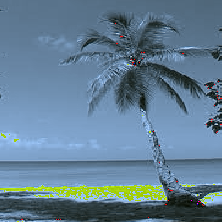

In [38]:
temp_img = np.vstack([r_pred,g_pred,b_pred]).T.reshape((222,222,3))
Image.fromarray(temp_img)

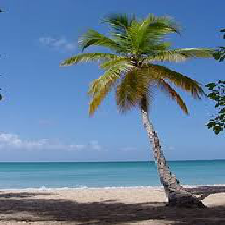

In [39]:
Image.open(train_img).resize((225,225))

In [40]:
x_test, y_test = get_matrix(test_img,1)

(225, 225)


In [41]:
r_pred = regr_r.predict(x_test).astype('uint8')
g_pred = regr_g.predict(x_test).astype('uint8')
b_pred = regr_b.predict(x_test).astype('uint8')

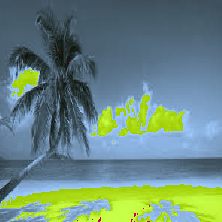

In [42]:
temp_img = np.vstack([r_pred,g_pred,b_pred]).T.reshape((222,222,3))
Image.fromarray(temp_img)

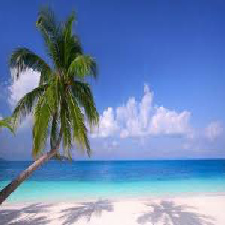

In [43]:
Image.open(test_img).resize((225,225))

# Clutering Method

We will note k cluster of rgb values and we will classifier each of the gray cell to the those 
clusters depending on their surrounding 9 cells neighborings.

We will first use k mean clustering on the rgb space and then do classification on it.

In [44]:
from sklearn.cluster import KMeans

In [45]:
x_train, y_train = get_matrix(train_img,1)
x_test, y_test = get_matrix(test_img,1)

(225, 225)
(225, 225)


In [46]:
kmeans = KMeans(n_clusters=32)
kmeans.fit(y_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=32, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [47]:
centroids = kmeans.cluster_centers_

In [48]:
labels = kmeans.predict(y_train)

In [49]:
x_train.shape, y_train.shape

((49284, 9), (49284, 3))

In [50]:
# make labels on the train set
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(x_train)

In [51]:
# make prediction on the test image
distances, indices = nbrs.kneighbors(x_test)

In [52]:
y_pred= []
for i in range(len(indices)):
    ls = list(labels[indices[i]])
    ss = set(ls)
    m = max(ss,key = lambda x: ls.count(x))
    y_pred.append(centroids[m])
y_pred = np.array(y_pred).astype('uint8')

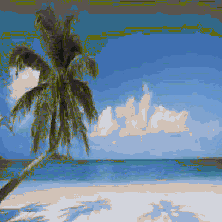

In [53]:
# predicted coloring graph
img_pred = Image.fromarray(y_pred.reshape((222,222,3)))
img_pred

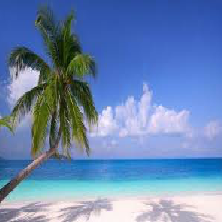

In [54]:
# original coloring graph
img_test = Image.fromarray(y_test.reshape((222,222,3)))
img_test

The picture seems to be much better then linear regression

# Reduced input (clustering)

In order to get smaller input size we will choose the non overlapping 3$\times$3 neighboring，which will reduce the input size by 9 and may make the prediction more robust.

In [55]:
# get images
# none overlapping
x_train, y_train = get_matrix(train_img, 3)
x_test, y_test = get_matrix(test_img, 3)


(225, 225)
(225, 225)


In [56]:
x_train.shape, y_train.shape


((5476, 9), (5476, 3))

In [57]:
# get labels k means
kmeans = KMeans(n_clusters=32)
kmeans.fit(y_train)
centroids = kmeans.cluster_centers_
labels = kmeans.predict(y_train)
x_train.shape, y_train.shape
# make prediction on the 
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(x_train)


In [58]:
# make prediction on the test image
distances, indices = nbrs.kneighbors(x_test)

y_pred= []
for i in range(len(indices)):
    ls = list(labels[indices[i]])
    ss = set(ls)
    m = max(ss,key = lambda x: ls.count(x))
    y_pred.append(centroids[m])
y_pred = np.array(y_pred).astype('uint8')


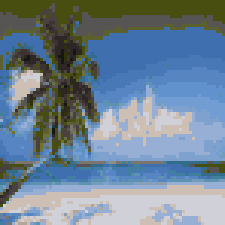

In [59]:
# predicted coloring graph
img_pred = Image.fromarray(y_pred.reshape((74,74,3))).resize((225,225))
img_pred

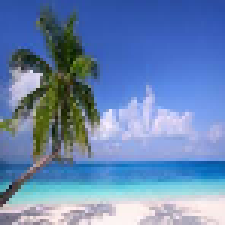

In [60]:
# original coloring graph
img_test = Image.fromarray(y_test.reshape((74,74,3))).resize((225,225))
img_test

The final result is a little worse than overlapping process, as

# Neural Network coloring 

In [31]:
x = []
y = []
image_size = 10
for k in range(1,2):
    for i in range(img_size-3):
        for j in range(img_size-3):
            print(i,j,k)
            box = (i,j,i+3,j+3)
            x.append(np.array(image_gray[k].crop(box)).reshape(-1,))
            y.append(np.array(image_color[k])[i+1,j+1]) 

NameError: name 'img_size' is not defined

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
model = Sequential()
#add model layers
model.add(Dense(64,activation='relu',input_dim = 9))
model.add(Dense(32,activation='relu'))
model.add(Dense(3, activation='linear'))

In [ ]:
model.compile(loss='mean_squared_error',
              optimizer='sgd')
model.fit(x, y, epochs=5, batch_size=1000)

In [ ]:
y_pred = model.predict(x)